In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc
import math
import numpy as np
import matplotlib.pyplot as plt

%env OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag/opt/oommf/oommf.tcl

env: OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag/opt/oommf/oommf.tcl


In [13]:
from scipy.spatial import cKDTree
import numpy as np

A =10.3e-12
Ms = 1.4e6
d = 60e-9

p1 = (-4*d, -4*d, -d/2)
p2 = (4*d, 4*d, d/2)
region = df.Region(p1=p1, p2=p2)
grains_mesh = df.Mesh(region=region, cell=(15e-9, 15e-9, 15e-9))  
# grains with size of # x= 2*d/5, y = (2*d)/6, z = (2*d)/5

In [14]:
all_grains_centres = list(grains_mesh)  # This extracts cell centre points of grains
all_grains_centres

[(-2.3249999999999997e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-2.1749999999999998e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-2.0249999999999997e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-1.8749999999999998e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-1.725e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-1.5749999999999997e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-1.4249999999999999e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-1.275e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-1.1249999999999998e-07, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-9.749999999999999e-08, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-8.25e-08, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-6.749999999999999e-08, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-5.25e-08, -2.3249999999999997e-07, -2.2499999999999996e-08),
 (-3.7499999999999985e-08, -2.324999999999

In [15]:
all_grains_centres = list(grains_mesh)  # This extracts cell centre points of grains
grain_centres_originals = np.array(all_grains_centres)
grain_centres_originals

array([[-2.325e-07, -2.325e-07, -2.250e-08],
       [-2.175e-07, -2.325e-07, -2.250e-08],
       [-2.025e-07, -2.325e-07, -2.250e-08],
       ...,
       [ 2.025e-07,  2.325e-07,  2.250e-08],
       [ 2.175e-07,  2.325e-07,  2.250e-08],
       [ 2.325e-07,  2.325e-07,  2.250e-08]])

In [16]:
#number of grains
num_rows,num_cols = grain_centres_originals.shape
Ngrains = num_rows
print(num_rows, num_cols)
print(Ngrains)

4096 3
4096


In [17]:
np.random.seed(111)
increament = np.random.uniform(-5e-9, 5e-9, size=(Ngrains,3))
increament

array([[ 1.12170176e-09, -3.30930246e-09, -6.39409806e-10],
       [ 2.69262473e-09, -2.04674696e-09, -3.50837043e-09],
       [-4.77521675e-09, -7.97755077e-10, -2.61317859e-09],
       ...,
       [ 2.16104786e-09, -1.15042977e-09, -1.61915942e-09],
       [-3.15380456e-09, -4.93494063e-09, -3.84400933e-09],
       [-2.36421557e-10,  2.57576155e-09, -4.70407740e-09]])

In [18]:
grain_centres = increament + grain_centres_originals
grain_centres

array([[-2.31378298e-07, -2.35809302e-07, -2.31394098e-08],
       [-2.14807375e-07, -2.34546747e-07, -2.60083704e-08],
       [-2.07275217e-07, -2.33297755e-07, -2.51131786e-08],
       ...,
       [ 2.04661048e-07,  2.31349570e-07,  2.08808406e-08],
       [ 2.14346195e-07,  2.27565059e-07,  1.86559907e-08],
       [ 2.32263578e-07,  2.35075762e-07,  1.77959226e-08]])

In [19]:
# Create positions to be grain centres, and create a cKDTree to
# perform Voronoi Tesselation
voronoi_kdtree = cKDTree(grain_centres)


# Generate random anisotropy axes
axes = np.random.uniform(-1, 1, (Ngrains, 3))
axes

array([[-0.93456974,  0.93987097,  0.22894133],
       [ 0.8576896 , -0.11185984, -0.81077734],
       [-0.764351  ,  0.63991798, -0.79222422],
       ...,
       [-0.61555682,  0.55017634, -0.30192862],
       [ 0.42142446,  0.27698199,  0.95339432],
       [-0.03160001, -0.624146  ,  0.71975022]])

In [20]:
# Weight them towards +z - assume grains oriented along field cooled direction
axes[:, 2] += 1.0
axes

array([[-0.93456974,  0.93987097,  1.22894133],
       [ 0.8576896 , -0.11185984,  0.18922266],
       [-0.764351  ,  0.63991798,  0.20777578],
       ...,
       [-0.61555682,  0.55017634,  0.69807138],
       [ 0.42142446,  0.27698199,  1.95339432],
       [-0.03160001, -0.624146  ,  1.71975022]])

In [21]:
# Normalise
axes /= np.linalg.norm(axes, axis=1)[:, np.newaxis]
axes

array([[-0.51704956,  0.51998246,  0.67991028],
       [ 0.96869299, -0.12633689,  0.21371212],
       [-0.75062801,  0.62842903,  0.20404542],
       ...,
       [-0.56934828,  0.50887577,  0.64566864],
       [ 0.20889063,  0.13729375,  0.96825365],
       [-0.01726984, -0.34110426,  0.93986682]])

In [22]:
# We then use the cKDTree in two functions. We get the x, y position
# of each micromagnetic cell, and query the tree for the region that
# the cell sits in. The functions then return the axis and strength
# at that region index.

def K_axis(pos):
    x, y, z = pos
    _, test_point_regions = voronoi_kdtree.query(np.array([[x, y, z]]), k=1)
    region = test_point_regions[0]
    return axes[region]

def K_mag(pos):
    x, y, z = pos
    _, test_point_regions = voronoi_kdtree.query(np.array([[x, y, z]]), k=1)
    region = test_point_regions[0]
    return strengths[region]

In [23]:
#after difining the grains with random anisotropy and desired size, 
#now lets us decrease the cell size for micromagnetic calculations

mesh = df.Mesh(region=region, cell=(2e-9, 2e-9, 2e-9))  # 2nm cell size
K = 0.5e5
u = df.Field(mesh, dim=3, value=K_axis)

# uniaxial anisotropy axis
system = mm.System(name='grain3')
system.energy = mm.UniaxialAnisotropy(K=K, u=u)

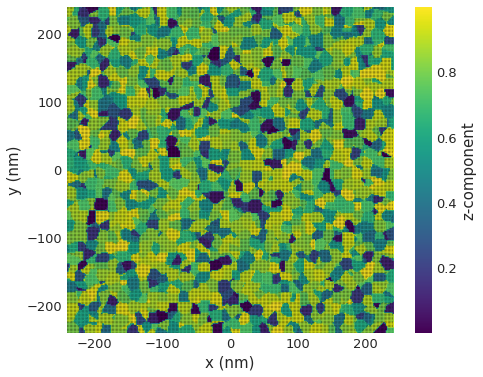

In [24]:
u.plane('z').mpl()

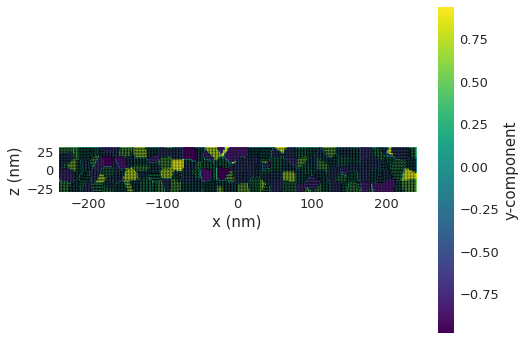

In [25]:
u.plane('y').mpl()

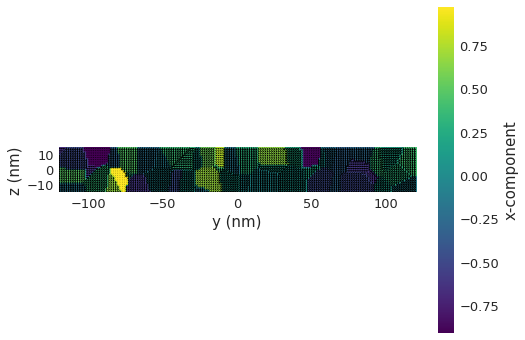

In [15]:
u.plane('x').mpl()

In [27]:
system = mm.System(name='try2')
B1_array = np.arange(0, -1, -0.1)

gamma0 = 0  # gyromagnetic ratio (m/As)
alpha = 0.25  # Gilbert damping
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)


system.energy = mm.Exchange(A=A) +  mm.UniaxialAnisotropy(K=K, u=u) + mm.Demag()+mm.Zeeman(H=(0, 0, 0))
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)

In [ ]:
md = mc.MinDriver()
md.drive(system, overwrite=True)

evolve = mc.CGEvolver()
md = mc.MinDriver(stopping_mxHxm=0.01)

mz = []
S1 = []
S2 = []
S3 = []
S4 = []
S5 = []
S6 = []

for B in B1_array:
    system.energy.zeeman.H = (0, 0,B/mm.consts.mu0)
    md.drive(system)
    mz.append(system.m.orientation.z.average)
    m1 = system.m.orientation.plane(z=30e-9)
    m2 = system.m.orientation.plane(z=15e-9)
    m3 = system.m.orientation.plane(z=0e-9)
    m4 = system.m.orientation.plane(z=-30e-9)
    m5 = system.m.orientation.plane(z=-15e-9)
    S1.append((m1 @ (m1.derivative('x') & m1.derivative('y'))).surface_integral / (4*math.pi))
    S2.append((m2 @ (m2.derivative('x') & m2.derivative('y'))).surface_integral / (4*math.pi))
    S3.append((m3 @ (m3.derivative('x') & m3.derivative('y'))).surface_integral / (4*math.pi))
    S4.append((m4 @ (m4.derivative('x') & m4.derivative('y'))).surface_integral / (4*math.pi))
    S5.append((m5 @ (m5.derivative('x') & m5.derivative('y'))).surface_integral / (4*math.pi))

Running OOMMF (TclOOMMFRunner) [2021/03/29 17:49]... (4003.1 s)
Running OOMMF (TclOOMMFRunner) [2021/03/29 19:12]... (110.2 s)


No handles with labels found to put in legend.


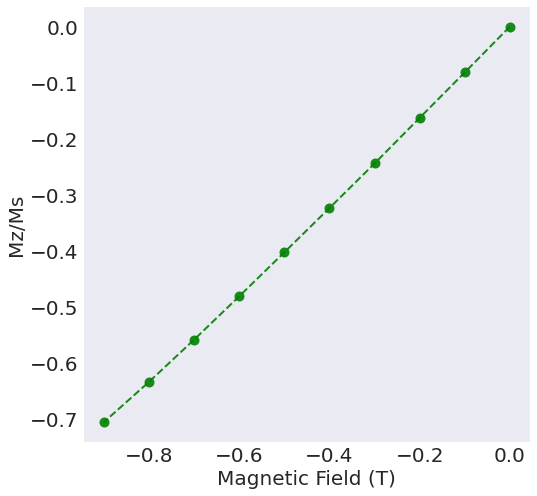

No handles with labels found to put in legend.


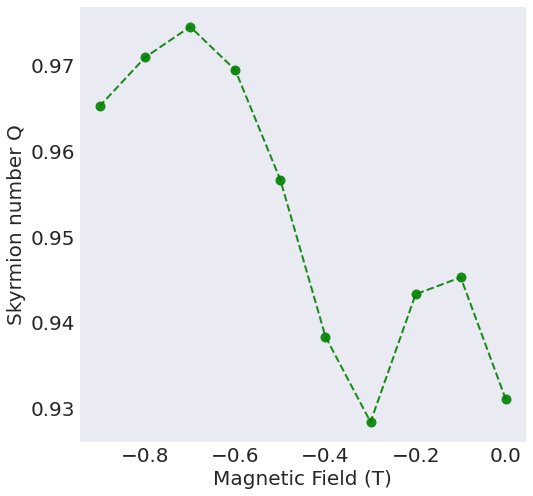

In [32]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,mz, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz/Ms', fontsize=20)
plt.legend()
plt.show()

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,S3, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Skyrmion number Q', fontsize=20)
plt.legend()
plt.show()

In [21]:
import micromagneticdata as md
data = md.Data(system.name)
@df.interact()
def interactive_plot(n=data.selector()):
    data.drive(n).step(0).plane(z=0).mpl()

interactive(children=(BoundedIntText(value=0, description='drive', max=11), Output()), _dom_classes=('widget-i…

In [25]:
import micromagneticdata as md
data = md.Data(system.name)
@df.interact()
def interactive_plot(n=data.selector()):
    data.drive(n).step(0).plane('x').mpl()

interactive(children=(BoundedIntText(value=0, description='drive', max=41), Output()), _dom_classes=('widget-i…

In [33]:
print(S1)
print(S2)
print(S3)
print(S4)
print(S5)

[0.6954704826632547, 0.7719291774776074, 0.8139095197782258, 0.830359611638599, 0.8379923485512818, 0.8376802564745292, 0.831606597078523, 0.8190474771064806, 0.8002103607285943, 0.7748958009029326]
[0.8886607055431288, 0.9116135768846508, 0.9207603944437304, 0.9187810377009495, 0.9312871562385991, 0.9442732295296921, 0.9499702877834111, 0.9470919213195544, 0.9381073710498512, 0.9311925891455595]
[0.9310507811219916, 0.9452910801031985, 0.9433145148128256, 0.9284124457913273, 0.9383863345079042, 0.9566638466907916, 0.9694833006974942, 0.9745391839975126, 0.9709557314027065, 0.9653131964538781]
[0.6974797600047874, 0.7678700305354351, 0.8067998098611412, 0.8246372445969528, 0.8340522669738342, 0.836527942165137, 0.8322974868013647, 0.8219731974702278, 0.8042742668409217, 0.7755121489015209]
[0.8816414551704579, 0.9063777192755688, 0.9129992506438164, 0.9085242726500959, 0.9211174777104216, 0.9375397022547437, 0.9470435968164792, 0.9486737138853555, 0.9419024943665493, 0.9322427991110577